# Batch anomaly detection

## Initialization
Package imports and client creation

In [1]:
import trendminer
import os
import pandas as pd
from trendminer.trendminer_client import TrendMinerClient
from trendminer_experimental.anomaly_detection.model import TMAnomalyModel
from matplotlib import pyplot as plt

# Grab user token
token = os.environ["KERNEL_USER_TOKEN"]

# Create TrendMiner API object
client = TrendMinerClient(token)

## Load training data
The anomaly model training data is loaded from a prepared view of batch profiles resulting in good quality product. The resulting list contains a dataframe for each batch, which in turn contains the process data for 7 tags.

In [2]:
# Loading TrendHub view: BP2 normal profile
from trendminer.views.views import Views

views = Views(client)
df_list = views.load_view('db880322-9a7a-4b05-8b81-d451301ba0e2')

df_list[0]

,TM-BP2-CONC.1,TM-BP2-CW.1,TM-BP2-LEVEL.1,TM-BP2-PRESSURE.1,TM-BP2-SPEED.1,TM-BP2-TEMP.1,TM-BP2-UTIL.1
2019-01-20 19:33:00+00:00,0.407739,-0.528559,0.000000,0.000000,0.000000,-0.205621,-0.579259
2019-01-20 19:34:00+00:00,0.455935,-0.596131,0.740882,0.740882,0.740882,-0.066930,-0.440797
2019-01-20 19:35:00+00:00,0.504131,0.103919,2.905884,2.905884,2.905884,1.219127,2.052726
2019-01-20 19:36:00+00:00,1.402205,0.170672,4.343985,4.343985,4.343985,2.505184,3.810494
2019-01-20 19:37:00+00:00,2.300280,0.640564,6.713532,6.713532,6.713532,2.953179,5.568263
...,...,...,...,...,...,...,...
2019-01-20 20:42:00+00:00,34.139423,27.046387,0.000000,6.713532,-6.581732,0.063894,25.258022
2019-01-20 20:43:00+00:00,33.429237,26.057686,0.000000,4.343985,-4.343985,0.170663,24.925154
2019-01-20 20:44:00+00:00,34.094822,23.691582,0.000000,2.905884,-2.905884,-0.248234,22.270119
2019-01-20 20:45:00+00:00,15.989095,21.325478,0.000000,0.740882,-0.740882,-0.667131,20.319840


## Training the model
The anomaly detection self organizing map model is trained on the good quality batches for 1000 iterations. To check our model quality, we can plot the quantization (lower means better model prediction, profile should converge) and topological error (degreed of twisting of the map, should not be out of control) over those iterations.

1000it [01:01, 16.34it/s]


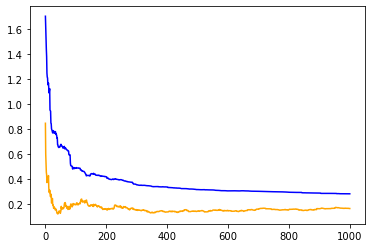

In [3]:
model = TMAnomalyModel()
q_error, topo_error = model.fit(df_list, 1000, verbose=False)

# Plot errors to check convergence
plt.plot(q_error, color="blue")
plt.plot(topo_error, color="orange")

## Publishing the model
The model can now be published so it can be used in the Tag Builder to create new tags. We can now make an anomaly score tag for this batch process that can hopefully notify us of any anomalies in our data.

In [7]:
# Publish the model
from trendminer.ml.models import ZementisModels
from pprint import pprint

# Enter model name. No spaces
model_name = "BP2_ANOMALY"

models = ZementisModels(client)

# Delete existing model if present; 
try:
    models.delete_model(model_name)
except trendminer.ml.models.exceptions.MLModelNotFoundException:
    pass

model_pmml = model.to_pmml(model_name, threshold_percentage=0.9)

# Replace variable names
for i, s in enumerate(df_list[0].columns):
    model_pmml = model_pmml.replace(f"Variable_{i}", s)

model_id = models.deploy_model(model_pmml)
model_details = models.model_details(model_id)

# Output model details for validation
pprint(model_details)

{'active': True,
 'description': 'SOM for anomaly detection',
 'inputFields': [{'name': 'TM-BP2-CONC.1', 'type': 'DOUBLE', 'usage': 'ACTIVE'},
                 {'name': 'TM-BP2-CW.1', 'type': 'DOUBLE', 'usage': 'ACTIVE'},
                 {'name': 'TM-BP2-LEVEL.1',
                  'type': 'DOUBLE',
                  'usage': 'ACTIVE'},
                 {'name': 'TM-BP2-PRESSURE.1',
                  'type': 'DOUBLE',
                  'usage': 'ACTIVE'},
                 {'name': 'TM-BP2-SPEED.1',
                  'type': 'DOUBLE',
                  'usage': 'ACTIVE'},
                 {'name': 'TM-BP2-TEMP.1', 'type': 'DOUBLE', 'usage': 'ACTIVE'},
                 {'name': 'TM-BP2-UTIL.1',
                  'type': 'DOUBLE',
                  'usage': 'ACTIVE'}],
 'links': [{'href': 'http://tm-timeseries-builder.trendminer.svc.cluster.local/tb/machinelearning/model/BP2_ANOMALY?engineType=ZEMENTIS',
            'rel': 'self'}],
 'modelName': 'BP2_ANOMALY',
 'outputFields': [{'name':